In [28]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import tensorflow as tf
import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError as MSE
from tensorflow.keras.optimizers import Adam


In [21]:
tf.compat.v1.logging.set_verbosity(30)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
df = pd.read_csv("data/porto.csv", index_col=[0], decimal=",")
df.dropna(inplace=True)
df = df.iloc[35136:]
#df.drop(['Location'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)
df['Energy'] = df['Energy'].astype(np.float32)
df

,Energy,Location
Time,,
2019-01-01 00:00:00,2.322959,1
2019-01-01 00:15:00,2.371797,1
2019-01-01 00:30:00,2.415961,1
2019-01-01 00:45:00,2.302538,1
2019-01-01 01:00:00,2.363063,1
...,...,...
2020-01-01 22:45:00,0.753222,50
2020-01-01 23:00:00,0.716855,50
2020-01-01 23:15:00,0.735802,50


<Axes: xlabel='Time'>

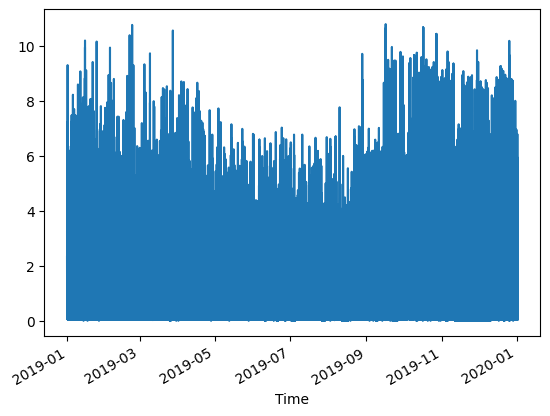

In [23]:
energy = df['Energy']
energy.plot()

In [24]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [25]:
data_list = []
scaler_list = []

# Iterate over each house
for house_id in df['Location'].unique():
    house_data = df[df['Location'] == house_id]['Energy'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(house_data)
    data_list.append(scaled_data)
    scaler_list.append(scaler)

# Split the dataset for each house into training and testing sets
train_data_list = []
test_data_list = []
train_size = int(len(data_list[0]) * 0.8)  # 80% for training, 20% for testing

for data in data_list:
    train_data_list.append(data[:train_size])
    test_data_list.append(data[train_size:])

In [26]:
sequence_length = 100  # adjust as needed

train_X_list, train_y_list = [], []
test_X_list, test_y_list = [], []

for train_data, test_data in zip(train_data_list, test_data_list):
    train_X, train_y = [], []
    test_X, test_y = [], []

    for i in range(len(train_data) - sequence_length):
        train_X.append(train_data[i:i+sequence_length])
        train_y.append(train_data[i+sequence_length])

    for i in range(len(test_data) - sequence_length):
        test_X.append(test_data[i:i+sequence_length])
        test_y.append(test_data[i+sequence_length])

    train_X_list.append(train_X)
    train_y_list.append(train_y)
    test_X_list.append(test_X)
    test_y_list.append(test_y)

# Convert to NumPy arrays
train_X = np.concatenate(train_X_list)
train_y = np.concatenate(train_y_list)
test_X = np.concatenate(test_X_list)
test_y = np.concatenate(test_y_list)

In [ ]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(train_X, train_y, epochs=10, batch_size=2)

In [31]:
predictions = model.predict(test_X)
mse = np.mean(np.square(predictions - test_y))
print(" Mean Squared Error (MSE):", mse)

10966/10966 [==============================] - 6s 529us/step
 Mean Squared Error (MSE): 0.006436881


In [35]:
performance_metrics(predictions, test_y)

MSE: 0.0064
WAPE: 32.75
R2: 0.7199


(0.0064, 32.75, 0.7199)

In [6]:
WINDOW_SIZE = 8
X1, y1 = df_to_X_y(energy, WINDOW_SIZE)
X1.shape, y1.shape

((35128, 8, 1), (35128,))

In [7]:
X_train1, y_train1 = X1[:25000], y1[:25000]
X_val1, y_val1 = X1[25000:30000], y1[25000:30000]
X_test1, y_test1 = X1[30000:], y1[30000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((25000, 8, 1), (25000,), (5000, 8, 1), (5000,), (5128, 8, 1), (5128,))

In [8]:
model = Sequential()
model.add(InputLayer((8, 1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [12]:
cp1 = ModelCheckpoint('models/model5', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MSE()])

In [13]:
model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1], batch_size=2)

Epoch 1/10
12460/12500 [============================>.] - ETA: 0s - loss: 0.3230 - mean_squared_error: 0.3230

12500/12500 [==============================] - 21s 2ms/step - loss: 0.3226 - mean_squared_error: 0.3226 - val_loss: 0.2668 - val_mean_squared_error: 0.2668
Epoch 2/10
12486/12500 [============================>.] - ETA: 0s - loss: 0.2489 - mean_squared_error: 0.2489

12500/12500 [==============================] - 19s 2ms/step - loss: 0.2491 - mean_squared_error: 0.2491 - val_loss: 0.2623 - val_mean_squared_error: 0.2623
Epoch 3/10
12500/12500 [==============================] - 17s 1ms/step - loss: 0.2472 - mean_squared_error: 0.2472 - val_loss: 0.2643 - val_mean_squared_error: 0.2643
Epoch 4/10
12477/12500 [============================>.] - ETA: 0s - loss: 0.2460 - mean_squared_error: 0.2460

12500/12500 [==============================] - 18s 1ms/step - loss: 0.2459 - mean_squared_error: 0.2459 - val_loss: 0.2598 - val_mean_squared_error: 0.2598
Epoch 5/10
12478/12500 [============================>.] - ETA: 0s - loss: 0.2457 - mean_squared_error: 0.2457

12500/12500 [==============================] - 18s 1ms/step - loss: 0.2455 - mean_squared_error: 0.2455 - val_loss: 0.2595 - val_mean_squared_error: 0.2595
Epoch 6/10
12500/12500 [==============================] - 17s 1ms/step - loss: 0.2448 - mean_squared_error: 0.2448 - val_loss: 0.2598 - val_mean_squared_error: 0.2598
Epoch 7/10
12500/12500 [==============================] - 18s 1ms/step - loss: 0.2440 - mean_squared_error: 0.2440 - val_loss: 0.2628 - val_mean_squared_error: 0.2628
Epoch 8/10
12493/12500 [============================>.] - ETA: 0s - loss: 0.2435 - mean_squared_error: 0.2435

12500/12500 [==============================] - 19s 1ms/step - loss: 0.2435 - mean_squared_error: 0.2435 - val_loss: 0.2589 - val_mean_squared_error: 0.2589
Epoch 9/10
12500/12500 [==============================] - 17s 1ms/step - loss: 0.2430 - mean_squared_error: 0.2430 - val_loss: 0.2617 - val_mean_squared_error: 0.2617
Epoch 10/10
12500/12500 [==============================] - 17s 1ms/step - loss: 0.2429 - mean_squared_error: 0.2429 - val_loss: 0.2589 - val_mean_squared_error: 0.2589


In [14]:
from tensorflow.keras.models import load_model
model1 = load_model('models/model5')
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [15]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

782/782 [==============================] - 1s 580us/step


,Train Predictions,Actuals
0,2.245748,2.341043
1,2.263454,2.402921
2,2.313446,2.342396
3,2.254609,2.443886
4,2.351959,2.406489
...,...,...
24995,0.275247,0.166444
24996,0.249741,0.112070
24997,0.225197,0.192155
24998,0.269142,0.144055


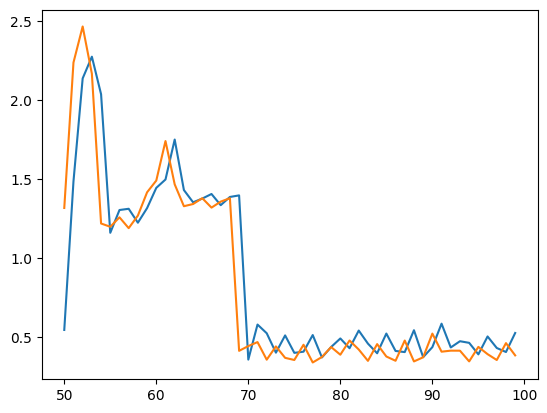

In [16]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [17]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

157/157 [==============================] - 0s 600us/step


,Val Predictions,Actuals
0,0.236588,0.165583
1,0.252686,0.144178
2,0.238791,0.185635
3,0.262945,0.729869
4,0.828417,1.416066
...,...,...
4995,0.380408,0.249359
4996,0.293945,0.323170
4997,0.389797,0.985994
4998,1.084719,2.492602


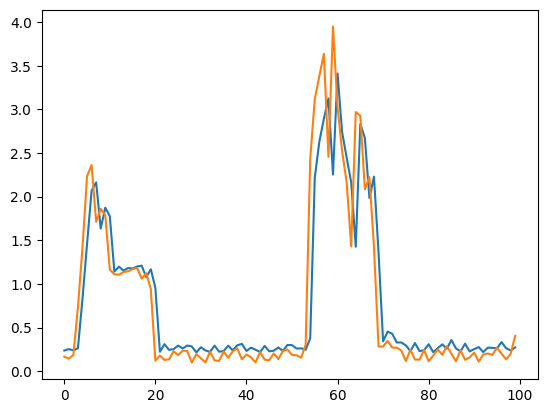

In [18]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [19]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

161/161 [==============================] - 0s 556us/step


,Test Predictions,Actuals
0,2.138252,2.604056
1,2.394081,3.562986
2,3.048004,2.197603
3,2.006993,2.939159
4,2.776993,2.713666
...,...,...
5123,2.884098,2.244719
5124,2.010986,2.136340
5125,2.118275,2.192805
5126,2.133162,1.446083


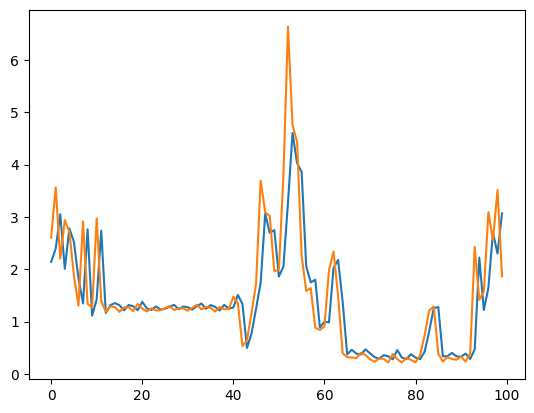

In [20]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

In [21]:
# mostrar erro (diferencça entre real e simulado)

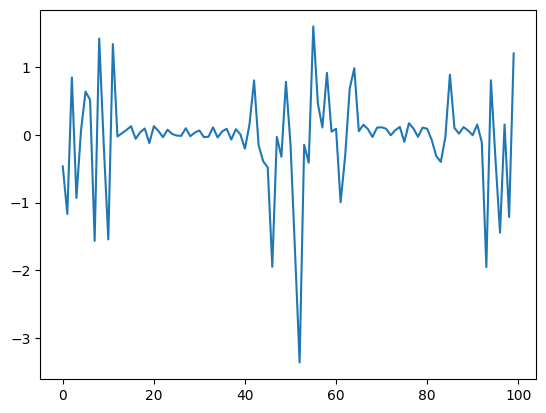

In [32]:
diff = test_results['Test Predictions'] - test_results['Actuals']
#plt.plot(range(test_results.shape[0]), diff)
plt.plot(range(100), diff[:100])

In [34]:
def truncate_metric(metric):
    m = math.trunc(10000 * metric) / 10000
    return m 

In [32]:
def performance_metrics(preds: np.array, actuals: np.array):

    # calculate performance metrics
    
    mse = truncate_metric(mean_squared_error(actuals, preds))
    wape = truncate_metric(np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals))) * 100
    r2 = truncate_metric(r2_score(actuals, preds))
    
    # print performance metrics
    print('MSE: %.4f' % mse)
    print('WAPE: %.2f' % wape)
    print('R2: %.4f' % r2)
    return mse, wape, r2

In [25]:
performance_metrics(train_results['Train Predictions'], train_results['Actuals'])

MSE: 0.2416
WAPE: 29.02
R2: 0.7419


(0.2416, 29.020000000000003, 0.7419)

In [26]:
performance_metrics(val_results['Val Predictions'], val_results['Actuals'])

MSE: 0.2588
WAPE: 28.04
R2: 0.7285


(0.2588, 28.04, 0.7285)

In [27]:
performance_metrics(test_results['Test Predictions'], test_results['Actuals'])

MSE: 0.3654
WAPE: 24.48
R2: 0.7244


(0.3654, 24.48, 0.7244)